In [1]:
!pip install -q uszipcode
!pip install -q tensorflow-recommenders

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.


In [8]:
from datetime import datetime
import re
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import gensim.downloader
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter, OrderedDict
from gensim.parsing.preprocessing import *
import tensorflow_recommenders as tfrs
# import cudf as pd

In [9]:
ratings = pd.read_csv("/kaggle/input/movielens-1m/ratings.csv")
users = pd.read_csv("/kaggle/input/movielens-1m/users.csv")
movies = pd.read_csv("/kaggle/input/movielens-1m/movies.csv")

In [10]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
users.head(5)

,userId,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [12]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movies[['title', 'movie_year', 'genres']] = movies.apply(lambda row: pd.Series({
    'title': row['title'][:-7],
    'movie_year': row['title'][-5:-1],
    'genres': str(row['genres']).split('|') if not pd.isnull(row['genres']) else list()
}), axis=1)

In [14]:
movies.head(5)

,movieId,title,genres,movie_year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [15]:
def features_from_epoch(row):
    dt = datetime.fromtimestamp(row['timestamp'])
    return pd.Series({
        'hour': int(dt.strftime("%H")),
        'day': int(dt.strftime("%w")),
        'month': int(dt.strftime("%m"))
    })

ratings[['hour','day','month']] = ratings.apply(features_from_epoch, axis=1)
ratings.head()

,userId,movieId,rating,timestamp,hour,day,month
0,1,1193,5,978300760,22,0,12
1,1,661,3,978302109,22,0,12
2,1,914,3,978301968,22,0,12
3,1,3408,4,978300275,22,0,12
4,1,2355,5,978824291,23,6,1


In [16]:
from uszipcode import SearchEngine
zip_code_search = SearchEngine()

Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


In [17]:
def user_features(row):
    zip_code = int(str(row['zip'])[:5]) if not pd.isnull(row['zip']) else 0
    try:
        z = zip_code_search.by_zipcode(zip_code).to_dict()
        return pd.Series({
            'gender': int(row['gender'] == 'F'),
            'city': z.get('major_city', ''),
            'state': z.get('state', ''),
            'zip': zip_code
        })
    except:
        return pd.Series({
            'gender': int(row['gender'] == 'F'),
            'city': 'XX',
            'state': 'XX',
            'zip': zip_code
        })

users[['gender', 'city', 'state', 'zip']] = users.apply(user_features, axis=1)
users.head()

,userId,gender,age,occupation,zip,city,state
0,1,1,1,10,48067,Royal Oak,MI
1,2,0,56,16,70072,Marrero,LA
2,3,0,25,15,55117,Saint Paul,MN
3,4,0,45,7,2460,Newtonville,MA
4,5,0,25,20,55455,Minneapolis,MN


In [18]:
all_data = ratings.join(users.set_index('userId'), on='userId', how='inner', rsuffix='2').join(movies.set_index('movieId'), on='movieId', how='inner', rsuffix='2')
print(f'Samples count: {len(all_data.index)}')
all_data.head()

Samples count: 1000209


,userId,movieId,rating,timestamp,hour,day,month,gender,age,occupation,zip,city,state,title,genres,movie_year
0,1,1193,5,978300760,22,0,12,1,1,10,48067,Royal Oak,MI,One Flew Over the Cuckoo's Nest,[Drama],1975
120,2,1193,5,978298413,21,0,12,0,56,16,70072,Marrero,LA,One Flew Over the Cuckoo's Nest,[Drama],1975
1339,12,1193,4,978220179,23,6,12,0,25,12,32793,Winter Park,FL,One Flew Over the Cuckoo's Nest,[Drama],1975
1518,15,1193,4,978199279,18,6,12,0,25,7,22903,Charlottesville,VA,One Flew Over the Cuckoo's Nest,[Drama],1975
1747,17,1193,5,978158471,6,6,12,0,50,1,95350,Modesto,CA,One Flew Over the Cuckoo's Nest,[Drama],1975


In [19]:
all_data.to_csv('/kaggle/working/all_data.csv', index=False)

In [20]:
all_data = all_data.sort_values(by='timestamp', axis=0, ascending=True).reset_index(drop=True)
all_data['is_test'] = all_data.index % 20 == 0
print(f"Number of testing samples: {len(all_data[all_data['is_test']].index)}")

Number of testing samples: 50011


In [21]:
def genre_as_feature_name(genre): 
    # Here we remove any non-alphanumeric characters from the genre's name, and add a 'genre_' suffix to it
    return 'genre_'+re.sub('[\W_]+', '', genre.lower())

all_genres = all_data['genres'].explode().dropna().unique()
all_data[[genre_as_feature_name(g) for g in all_genres]] = all_data.apply(lambda row: pd.Series({genre_as_feature_name(g): float(g in row['genres']) for g in all_genres}), axis=1)
all_data = all_data.drop('genres', axis=1)
all_data.head()

,userId,movieId,rating,timestamp,hour,day,month,gender,age,occupation,...,genre_romance,genre_war,genre_filmnoir,genre_mystery,genre_documentary,genre_fantasy,genre_scifi,genre_animation,genre_western,genre_horror
0,6040,858,4,956703932,23,2,4,0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6040,593,5,956703954,23,2,4,0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6040,2384,4,956703954,23,2,4,0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6040,2019,5,956703977,23,2,4,0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6040,1961,4,956703977,23,2,4,0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
word2vec = gensim.downloader.load('glove-twitter-25')

[===============================================---] 95.3% 99.8/104.8MB downloaded

In [ ]:
def safe_embbed_word(word, length=25):
    try:
        return word2vec[word.lower()]
    except KeyError:
        return np.zeros(length)
    
def embbed_title(row):
    words = strip_multiple_whitespaces(remove_stopwords(split_alphanum(strip_non_alphanum(strip_punctuation(row['title']))))).split(' ')  # all functions are imported from gensim.parsing.preprocessing
    embs = np.array([safe_embbed_word(w) for w in words])
    return pd.Series({f'title_emb_{i}': v for i,v in enumerate(embs.sum(axis=0))})
    
all_data[[f'title_emb_{i}' for i in range(25)]] = all_data.apply(embbed_title, axis=1)
all_data = all_data.drop('title', axis=1)
all_data.head()

In [24]:
all_data = all_data.drop(['zip', 'timestamp'], axis=1)   
test_data = all_data[all_data['is_test']].drop('is_test', axis=1)
train_data = all_data[~all_data['is_test']].drop('is_test', axis=1)


In [25]:
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [26]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [27]:
metadata = dict()
metadata['title_emb_size'] = 25  # size of embedding of glove-twitter-25
metadata['string_na'] = 'XX'  # Defined in project 1.1
metadata['genres'] = [genre_as_feature_name(g) for g in all_genres]
metadata['ages'] = all_data['age'].unique().tolist()
metadata['occupations'] = all_data['occupation'].unique().tolist()

0.7983711404316498

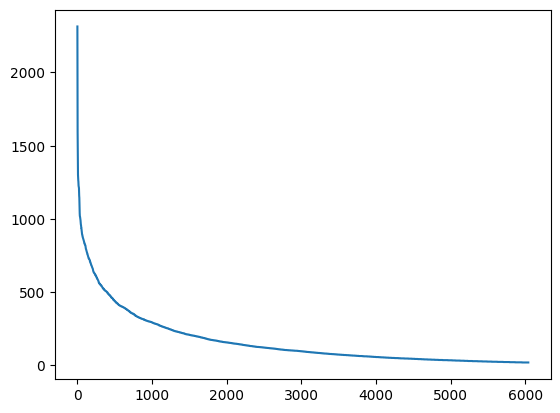

In [28]:
du = OrderedDict()
for k,v in sorted(Counter(all_data['userId']).items(), key=lambda item: -item[1]):
    du[k] = v
lu = list(du.values())
plt.plot(range(len(lu)), lu)
sum(lu[:2500])/sum(lu)

In [29]:
metadata['users'] = list(du.keys())[:2500]

0.8047208133500099

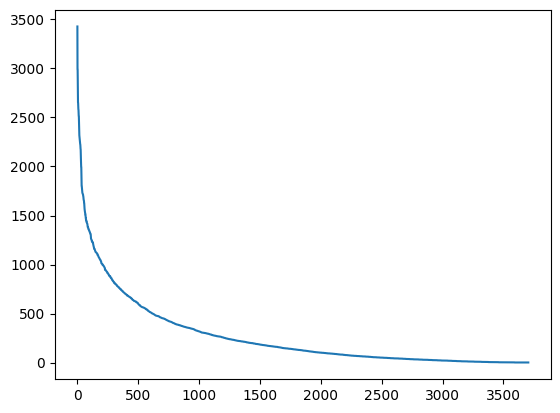

In [30]:
dm = OrderedDict()
for k,v in sorted(Counter(all_data['movieId']).items(), key=lambda item: -item[1]):
    dm[k] = v
lm = list(dm.values())
plt.plot(range(len(lm)), lm)
sum(lm[:1200])/sum(lm)

In [31]:
metadata['movies'] = list(dm.keys())[:1200]

0.8236910432314332

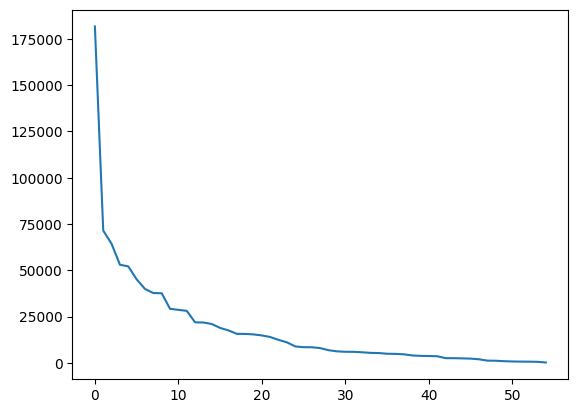

In [32]:
ds = OrderedDict()
for k,v in sorted(Counter(all_data['state']).items(), key=lambda item: -item[1]):
    if k != metadata['string_na']:
        ds[k] = v
ls = [x for x in ds.values() if x != metadata['string_na']]
plt.plot(range(len(ls)), ls)
sum(ls[:20])/sum(ls)

0.8155436661885366

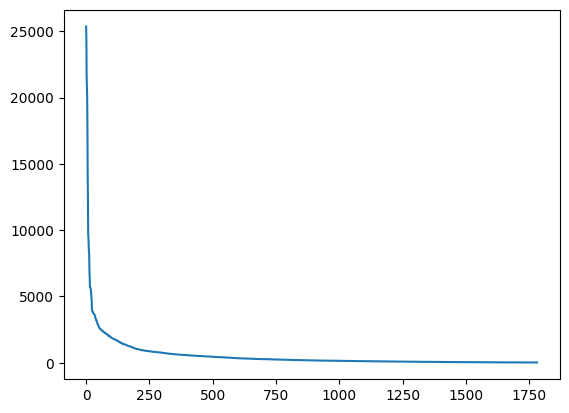

In [33]:
dc = OrderedDict()
for k,v in sorted(Counter(all_data['city']).items(), key=lambda item: -item[1]):
    if k != metadata['string_na']:
        dc[k] = v
lc = [x for x in dc.values() if x != metadata['string_na']]
plt.plot(range(len(lc)), lc)
sum(lc[:500])/sum(lc)

In [34]:
metadata['states'] = list(ds.keys())[:20]
metadata['cities'] = list(dc.keys())[:500]

In [35]:
with open('/kaggle/working/metadata.json', 'w+') as f:
    json.dump(metadata, f)

In [36]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]
all_cities = metadata['cities']
all_states = metadata['states']
all_ages = [str(int(i)) for i in metadata['ages']]
all_occupations = [str(int(i)) for i in metadata['occupations']]
all_genres = metadata['genres']
title_emb_len = metadata['title_emb_size']
na_value = metadata['string_na']

In [37]:
features = ["movieId", 'title_emb_0', 'title_emb_1', 'title_emb_2',
       'title_emb_3', 'title_emb_4', 'title_emb_5', 'title_emb_6',
       'title_emb_7', 'title_emb_8', 'title_emb_9', 'title_emb_10',
       'title_emb_11', 'title_emb_12', 'title_emb_13', 'title_emb_14',
       'title_emb_15', 'title_emb_16', 'title_emb_17', 'title_emb_18',
       'title_emb_19', 'title_emb_20', 'title_emb_21', 'title_emb_22',
       'title_emb_23', 'title_emb_24', 'genre_action',
       'genre_crime', 'genre_drama', 'genre_thriller', 'genre_childrens',
       'genre_comedy', 'genre_adventure', 'genre_musical', 'genre_romance',
       'genre_war', 'genre_filmnoir', 'genre_mystery', 'genre_documentary',
       'genre_fantasy', 'genre_scifi', 'genre_animation', 'genre_western',
       'genre_horror', 'movie_year']

def convert_to_dataset(df):
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_data)
test_dataset = convert_to_dataset(test_data)

In [41]:
# train_data['city'] = train_data['city'].astype('category')
# city_categories = train_data['city'].cat.categories
# train_data['city'] = train_data['city'].cat.codes

# Convert back to original categorical values
# df['city'] = pd.Categorical.from_codes(df['city'], categories=original_categories)

# train_data['state'] = train_data['state'].astype('category')
# state_categories = train_data['state'].cat.categories
# train_data['state'] = train_data['state'].cat.codes

# Convert back to original categorical values
# df['state'] = pd.Categorical.from_codes(df['state'], categories=original_categories)


In [42]:
class RetrievelModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        
        tower_last_layer_size = 50
        large_embedding_size = 25
        medium_embedding_size = 5
        small_embedding_size = 3

        
        
        # User Model
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.age_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='age_input')
        self.age_sl = tf.keras.layers.StringLookup(vocabulary=all_ages, num_oov_indices=0, name='age_string_lookup')(self.age_input)
        self.age_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_ages), small_embedding_size, name='age_emb')(self.age_sl), axis=1)
        
        self.occupation_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='occupation_input')
        self.occupation_sl = tf.keras.layers.StringLookup(vocabulary=all_occupations, num_oov_indices=0, name='occupation_string_lookup')(self.occupation_input)
        self.occupation_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_occupations), small_embedding_size, name='occupation_emb')(self.occupation_sl), axis=1)
        
        self.gender_input = tf.keras.Input(shape=(1,), name='gender_input')
        self.hour_input = tf.keras.Input(shape=(1,), name='hour_input')
        self.day_input = tf.keras.Input(shape=(1,), name='day_input')
        self.month_input = tf.keras.Input(shape=(1,), name='month_input')
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb, self.age_emb, 
                                                        self.occupation_emb, self.gender_input, self.hour_input,
                                                        self.day_input, self.month_input], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(100, activation='relu', name='user_dense')(self.user_merged)
        self.user_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='user_last_layer')(self.user_dense)
        self.user_model = tf.keras.Model(inputs={
            'userId': self.user_input, 
                                            'city': self.city_input,
                                            'state': self.state_input,
                                            'age': self.age_input,
                                            'occupation': self.occupation_input,
                                            'gender': self.gender_input,
                                            'hour': self.hour_input,
                                            'day': self.day_input,
                                            'month': self.month_input,
        }, 
                                          outputs=self.user_last_layer)
        
        # Movie Model
        
        self.movie_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, large_embedding_size, name='movie_emb')(self.movie_sl), axis=1)
        
        self.title_input = tf.keras.Input(shape=(title_emb_len,), name='title_input')
        self.title_dense = tf.keras.layers.Dense(title_emb_len, activation='softmax', name='title_softmax')(self.title_input)
        
        self.genres_input = tf.keras.Input(shape=(len(all_genres),), name='genres_input')
        self.year_input = tf.keras.Input(shape=(1,), name='year_input')
        
        self.movie_merged = tf.keras.layers.concatenate([self.movie_emb, self.title_dense, self.genres_input, self.year_input] ,axis=-1, name='movie_merged')
        self.movie_dense = tf.keras.layers.Dense(100, activation='relu', name='movie_dense')(self.movie_merged)
        self.movie_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='movie_last_layer')(self.movie_dense)
        self.movie_model = tf.keras.Model(inputs={
            'movieId': self.movie_input,
            'movie_year': self.year_input,
            'genres': self.genres_input,
            'title_emb': self.title_input
        }, 
                                          outputs=self.movie_last_layer)
        
        
#         movie_title = tf.data.Dataset.from_tensor_slices(movies["title"].values)
        metrics = tfrs.metrics.FactorizedTopK(
            candidates=train_dataset.batch(128).map(self.movie_model)
        )
        task = tfrs.tasks.Retrieval(
            metrics=metrics
        )
        self.task: tf.keras.layers.Layer = task
            
    def compute_loss(self, features, training=False):
#         user_embeddings = self.user_model(features["userId"])
#         positive_movie_embeddings = self.movie_model(features["movieId"])
        user_embeddings = self.user_model({
            'userId': tf.strings.as_string(features["userId"]), 
                           'city': features["city"], 
                           'state': features["state"],
                           'age': tf.strings.as_string(features["age"]),
                           'occupation': tf.strings.as_string(features["occupation"]), 
                           'gender': features["gender"],
                           'hour': features["hour"],
                           'day': features["day"],
                           'month': features["month"]
                                          })
        positive_movie_embeddings = self.movie_model({
            'movieId': tf.strings.as_string(features["movieId"]),
           'movie_year': features["movie_year"],
            'title_emb': features["title_emb"],
           'genres': features["genres"]
        })

        return self.task(user_embeddings, positive_movie_embeddings)

In [43]:
all_train_dataset = convert_to_dataset(train_data)
all_test_dataset = convert_to_dataset(test_data)

In [74]:
# tf.random.set_seed(42)
# shuffled = all_train_dataset.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

# train = shuffled.take(80_000)
# test = shuffled.skip(80_000).take(20_000)

In [44]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        tower_last_layer_size = 50
        large_embedding_size = 25
        medium_embedding_size = 5
        small_embedding_size = 3
        
        # User tower
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.age_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='age_input')
        self.age_sl = tf.keras.layers.StringLookup(vocabulary=all_ages, num_oov_indices=0, name='age_string_lookup')(self.age_input)
        self.age_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_ages), small_embedding_size, name='age_emb')(self.age_sl), axis=1)
        
        self.occupation_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='occupation_input')
        self.occupation_sl = tf.keras.layers.StringLookup(vocabulary=all_occupations, num_oov_indices=0, name='occupation_string_lookup')(self.occupation_input)
        self.occupation_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_occupations), small_embedding_size, name='occupation_emb')(self.occupation_sl), axis=1)
        
        self.gender_input = tf.keras.Input(shape=(1,), name='gender_input')
        self.hour_input = tf.keras.Input(shape=(1,), name='hour_input')
        self.day_input = tf.keras.Input(shape=(1,), name='day_input')
        self.month_input = tf.keras.Input(shape=(1,), name='month_input')
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb, self.age_emb, 
                                                        self.occupation_emb, self.gender_input, self.hour_input,
                                                        self.day_input, self.month_input], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(100, activation='relu', name='user_dense')(self.user_merged)
        self.user_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='user_last_layer')(self.user_dense)
        
        # Movie tower
        
        self.movie_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, large_embedding_size, name='movie_emb')(self.movie_sl), axis=1)
        
        self.title_input = tf.keras.Input(shape=(title_emb_len,), name='title_input')
        self.title_dense = tf.keras.layers.Dense(title_emb_len, activation='softmax', name='title_softmax')(self.title_input)
        
        self.genres_input = tf.keras.Input(shape=(len(all_genres),), name='genres_input')
        self.year_input = tf.keras.Input(shape=(1,), name='year_input')
        
        self.movie_merged = tf.keras.layers.concatenate([self.movie_emb, self.title_dense, self.genres_input, self.year_input] ,axis=-1, name='movie_merged')
        self.movie_dense = tf.keras.layers.Dense(100, activation='relu', name='movie_dense')(self.movie_merged)
        self.movie_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='movie_last_layer')(self.movie_dense)
        
        # Combining towers
        
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([self.user_last_layer, self.movie_last_layer])
        self.towers_dense1 = tf.keras.layers.Dense(40, activation='relu', name='towers_dense1')(self.towers_multiplied)
        self.towers_dense2 = tf.keras.layers.Dense(20, activation='relu', name='towers_dense2')(self.towers_dense1)
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense2)
        
        # Model definition
        
        self.model = tf.keras.Model(inputs={'userId': self.user_input, 
                                            'city': self.city_input,
                                            'state': self.state_input,
                                            'age': self.age_input,
                                            'occupation': self.occupation_input,
                                            'gender': self.gender_input,
                                            'hour': self.hour_input,
                                            'day': self.day_input,
                                            'month': self.month_input,
                                            'movieId': self.movie_input,
                                            'title': self.title_input,
                                            'genres': self.genres_input,
                                            'year': self.year_input
                                            }, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'userId': tf.strings.as_string(features["userId"]), 
                           'city': features["city"], 
                           'state': features["state"],
                           'age': tf.strings.as_string(features["age"]),
                           'occupation': tf.strings.as_string(features["occupation"]), 
                           'gender': features["gender"],
                           'hour': features["hour"],
                           'day': features["day"],
                           'month': features["month"],
                           'movieId': tf.strings.as_string(features["movieId"]),
                           'title': features["title_emb"],
                           'genres': features["genres"],
                           'year': features["movie_year"]
                           })
    
    def compute_loss(self, features, **kwargs):
        return self.task(labels=features["rating"], predictions=self(features))

In [46]:
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

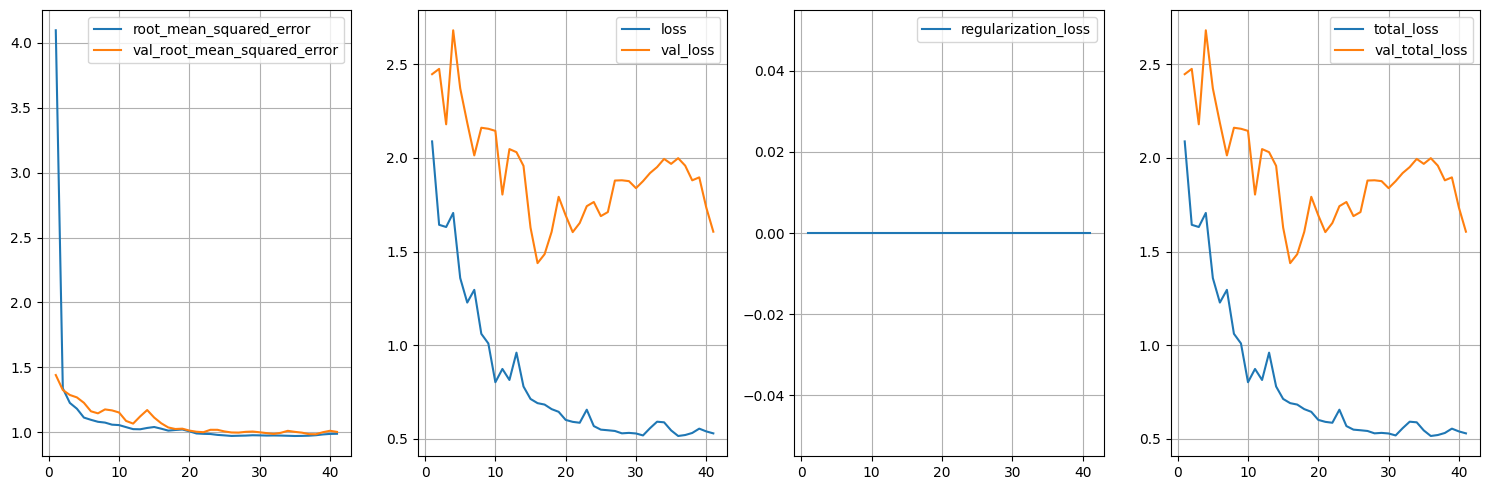

96/96 [==============================] - 3s 32ms/step - root_mean_squared_error: 0.9883 - loss: 0.9676 - regularization_loss: 0.0000e+00 - total_loss: 0.9676 - val_root_mean_squared_error: 1.0027 - val_loss: 1.6061 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.6061


In [49]:
# model = RetrievelModel()
# model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
# cached_train = train.shuffle(100_000).batch(8192).cache()
# cached_test = test.batch(4096).cache()
# model.fit(cached_train, epochs=3)
callbacks_list = [PlotLearning()]

with tf.device("/GPU:1"):
    model = RatingPredictionModel()
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(2e-3, decay_steps=4000, decay_rate=0.95)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
    cached_val_train = test_dataset.shuffle(15_000).batch(10_000).cache()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=5)
    callbacks_list.append(early_stopping)

    history = model.fit(cached_train, validation_data=cached_val_train, epochs=100, callbacks=callbacks_list)

In [54]:
model.save_weights("model_val_weights.h5")

In [128]:
# with tf.device("/GPU:1"):
    # import tqdm

    # def convert_to_dataset(df):
    #     d = {}
    #     batch_size = 10000
    #     for i in tqdm.tqdm(range(0, len(df), batch_size)):
    #         batch_data = df.iloc[i: i+batch_size]
    #         batch_d = {k:v.to_numpy() for k,v in dict(batch_data).items()}
    #         batch_d['genres'] = np.transpose(np.array([batch_d[x] for x in all_genres]))
    #         batch_d['title_emb'] = np.transpose(np.array([batch_d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    #         for x in all_genres:
    #             batch_d.pop(x)
    #         for x in [f'title_emb_{i}' for i in range(title_emb_len)]:
    #             batch_d.pop(x)
    #         for key, val in batch_d.items():
    #             if key not in d:
    #                 d[key] = None
    #             if d[key] is None:
    #                 d[key] = val
    #             else:
    #                 d[key] = np.concatenate((d[key], val))

    #     return tf.data.Dataset.from_tensor_slices(d)

In [55]:
loaded_model = RatingPredictionModel()
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(2e-3, decay_steps=4000, decay_rate=0.95)
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


loaded_model.built = True
loaded_model.load_weights("model_val_weights.h5")


/opt/conda/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [57]:
import datetime

def make_dataset(user_ids_batch, user_df, movies_df, epoch_time = 1680480000, num_recs = 15):
    selected_user_data = user_df[user_df['userId'].isin(user_ids_batch)][['userId', 'state', 'city', 'age', 'occupation', 'gender']].drop_duplicates()
    user_metadata_batch = pd.concat([selected_user_data] * len(movies_df), ignore_index=True).sort_values(by='userId').reset_index(drop=True)
    # Duplicate top_genres_df for each user in the batch
    top_genres_batch = pd.concat([movies_df] * len(user_ids_batch), ignore_index=True)

    # Combine user metadata and top genres DataFrames
    combined_df = pd.concat([user_metadata_batch, top_genres_batch], axis=1)
    combined_df['hour'] = datetime.datetime.fromtimestamp(epoch_time).hour
    combined_df['day'] = datetime.datetime.fromtimestamp(epoch_time).day
    combined_df['month'] = datetime.datetime.fromtimestamp(epoch_time).month
        
    all_genres = combined_df['genres'].explode().dropna().unique()
    combined_df[[genre_as_feature_name(g) for g in all_genres]] = combined_df.apply(lambda row: pd.Series({genre_as_feature_name(g): float(g in row['genres']) for g in all_genres}), axis=1)
    combined_df = combined_df.drop('genres', axis=1)
    
    combined_df[[f'title_emb_{i}' for i in range(25)]] = combined_df.apply(embbed_title, axis=1)
    combined_df = combined_df.drop('title', axis=1)
    combined_df = combined_df.astype({'movie_year': 'int64'})

    return combined_df 

def get_recommendation(user_id, top=10):
    top10 = []
    final_test_data = make_dataset([user_id], users, movies)
    final_test_data = final_test_data.drop_duplicates().dropna()
    for name, group in final_test_data.groupby("userId"):
        test_df = convert_to_dataset(group)
        cached_test = test_df.batch(500).cache()
        preds = loaded_model.predict(cached_test)
        group["predicted_rating"] = preds
        temp = group.sort_values(by='predicted_rating', axis=0, ascending=False).reset_index(drop=True)
        for movieid, rating in zip(temp.head(top)["movieId"].values.tolist(), temp.head(top)["predicted_rating"].values.tolist()):
            top10.append(movies.loc[movies['movieId'] == movieid]["title"].values[0])
        
        return top10
print(get_recommendation(42))

8/8 [==============================] - 0s 10ms/step
['Shawshank Redemption, The', 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai)', 'Godfather, The', 'Wrong Trousers, The', 'Usual Suspects, The', "Schindler's List", 'Close Shave, A', 'Sunset Blvd. (a.k.a. Sunset Boulevard)', 'Raiders of the Lost Ark', 'Rear Window']
